# Building RNN with Pytorch

Dans ce TD, nous allons construire un RNN from scratch avec Pytorch, en suivant les étapes suivantes:
1. Sur un problème linéaire, nous allons utiliser les torch optimizers pour trouver le paramètre de régression idéal
2. Sur un problème non-linéaire, nous allons construire un multi-layers perceptron
3. Sur un problème de texte, nous allons construire un modèle RNN

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch

## Optimizers

### Données example
Nous allons construire des données $y = \beta^* X + b$


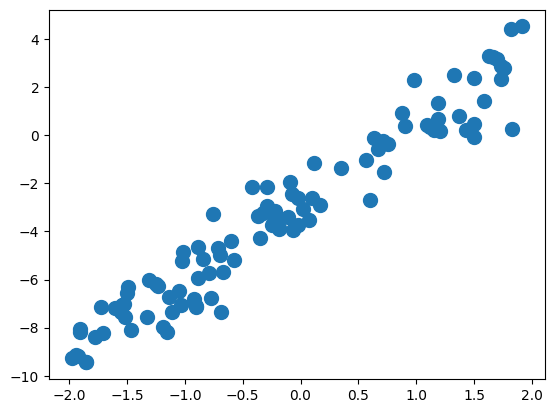

In [2]:
n = 100

a_star = 3.
b_star = -3.
noise_std = 1

x = (np.random.rand(n, 1) - 0.5) * 4
noise = np.random.normal(0, noise_std, (n, 1))
y = a_star * x + b_star + noise

x = torch.tensor(x, dtype=torch.float32)

xvec = x
plt.plot(x, y, 'o', markersize=10)

### Constuire l'optimizer

- Avec torch.nn.Parameter(), créer le paramètre beta qui sera optimisé. Les predictions du modèle sont égales à $\beta \times X$ 
- Avec torch.nn.MSELoss, déclarer la loss entre les prédictions et le résultat réel. loss.backward() pour mettre à jour les gradients
- Avec torch.optim.Adam, déclarer un optimizer
- Construisez la boucle qui, pour n_epochs, va reset les gradients, calculer la loss, mettre à jour les gradients et faire un pas pour optimiser beta

In [ ]:
# learning_rate = 0.01
# n_epochs = 10
# batch_size = 10
# loss = torch.nn.MSELoss()
# loss.backwards()
# optim = torch.optim.Adam(torch.nn.Parameter(), lr=learning_rate)
# for epoch in n_epochs:
#     # gradient to zero
#     # loss
#     # update gradient
#     # beta optimizer

In [3]:
beta = nn.Parameter(torch.tensor(1.0, dtype=torch.float32), requires_grad=True)
loss_fn = torch.nn.MSELoss()
optimizer = optim.Adam([beta], lr=0.01)
n_epochs = 1000

for epoch in range(n_epochs):
    optimizer.zero_grad()

    y_pred = beta * x

    loss = loss_fn(y_pred, y)
    loss.backward()

    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Époque [{epoch + 1}/{n_epochs}], Perte: {loss.item()}')

print(f'Valeur optimale de beta: {beta.item()}')

TypeError: 'int' object is not callable

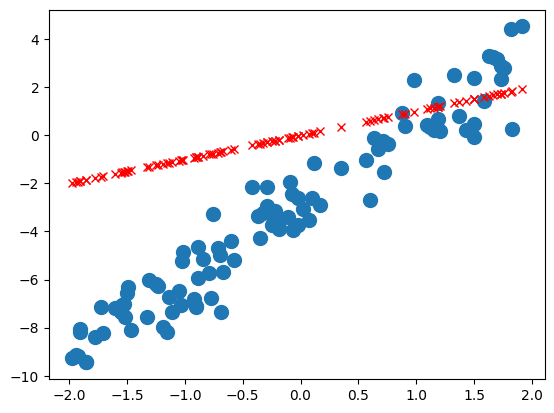

In [4]:
# Plot des predictions
plt.plot(x, y, 'o', markersize=10)
plt.plot(x, beta.item() * x, 'rx')

## Construire un multi-layer perceptron (MLP)

Ici, les données sont $y = a x^2 + b$

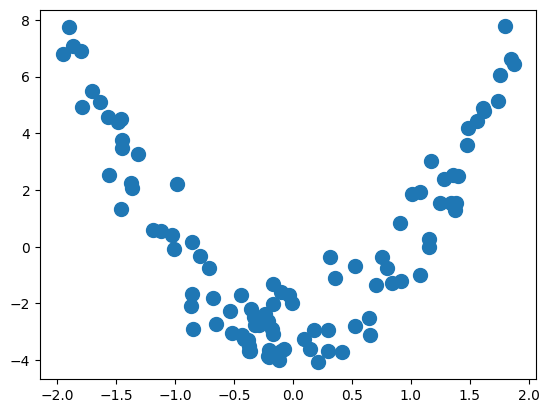

In [9]:
n = 100

a_star = 3.
b_star = -3.
noise_std = 1

x = (np.random.rand(n, 1) - 0.5) * 4
noise = np.random.normal(0, noise_std, (n, 1))
y = a_star * (x ** 2) + b_star + noise

x = torch.tensor(x, dtype=torch.float32)

xvec = x
plt.plot(x, y, 'o', markersize=10)

Nous allons construire un Pytorch modèle. Dans ce framework, on définit la fonction "forward" qui prend en argument les inputs et retourne les prédictions.

A l'aide de torch.nn.Module et de différentes layers (torch.nn.Linear, torch.nn.ReLU), terminez la classe ci-dessous pour créer un multi-layers perceptron 

In [8]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super().__init__()
        self.input_size = input_size
        self.hidden_layer1 = torch.nn.Linear(input_size, hidden_size1)
        self.hidden_layer2 = torch.nn.Linear(hidden_size1, hidden_size2)
        self.output_layer = torch.nn.Linear(hidden_size2, 1)

    def forward(self, X):
        X = torch.relu(self.hidden_layer1(X))
        X = torch.relu(self.hidden_layer2(X))
        X = self.output_layer(X)
        return X

En utilisant le travail précédent, faite une cellule utilisant un torch optimizer pour optimiser le MLP

In [6]:
type(loss_fn)

torch.nn.modules.loss.MSELoss

In [10]:
# Définir un modèle MLP
input_size = 1
hidden_size1 = 64
hidden_size2 = 32
n_epochs = 1000

model = MLP(input_size, hidden_size1, hidden_size2)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(n_epochs):
    optimizer.zero_grad()

    y_pred = model(x)

    loss = loss_fn(y_pred, y)
    loss.backward()

    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Époque [{epoch + 1}/{n_epochs}], Perte: {loss.item()}')

print("Perte finale:", loss.item())

TypeError: 'int' object is not callable

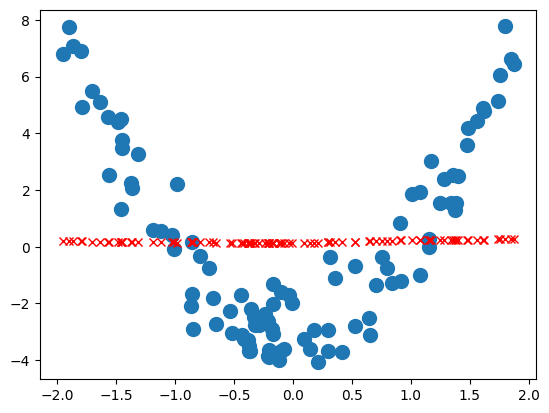

In [11]:
# Plot des predictions
plt.plot(x, y, 'o', markersize=10)
plt.plot(x, model(x).detach(), 'rx')

## Construire un Recurrent Neural Network (RNN) from scratch

### Données
 
Téléchargez [ici](https://download.pytorch.org/tutorial/data.zip) un jeu de données "nom" -> pays d'origine du nom.
Les noms de chaque pays sont dans leur fichier texte "[country].txt"

A partir de ces données, créez X la liste des noms et y le pays d'origine de chaque nom

### Aide pour générer les données

A la fin de ce code, on lit les noms et leur pays d'origine.<br>
On a une fonction randomTrainingExample, qui génère le pays d'origine et le nom (en texte), puis l'ID de ce pays et le tenseur représetant le nom. <br>

A partir de là, vous pouvez générer les données X, y comme vous voulez

In [21]:
# Code pour générer le jeu de données
# En admettant que les fichiers ont été extraits dans data/raw/names/

import math
import numpy as np
from pathlib import Path
import random
import string
import time
import unicodedata

path = Path("../data/names/")

In [24]:
def read_names(path):
    category_lines = {}
    for file in path.iterdir():
        if not file.name.endswith(".txt"):
            continue

        with open(file, encoding='utf-8') as f:
            names = [unicodeToAscii(line.strip()) for line in f]

        category = file.stem
        category_lines[category] = names

    return category_lines


# Handling ASCII stuff
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)


# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [25]:
category_lines = read_names(path)
all_categories = list(category_lines.keys())
n_categories = len(all_categories)

In [27]:

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)


# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor


# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [35]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]


def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

X = []
y = []

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    X.append(line)
    y.append(category)


for name, country in zip(X, y):
    print('Nom:', name, '| Pays:', country)

Nom: Truong | Pays: Vietnamese
Nom: Scott | Pays: Scottish
Nom: Shaw | Pays: Scottish
Nom: Liatos | Pays: Greek
Nom: Overett | Pays: English
Nom: Turyansky | Pays: Russian
Nom: Nahas | Pays: Arabic
Nom: Marshall | Pays: Scottish
Nom: Kahae | Pays: Japanese
Nom: Salazar | Pays: Portuguese


### Construire le RNN

Un Recurrent Neural Network prend, pour prédire un input X et un hidden state H.<br>
Il output une prédiction et un nouvel hidden state pour la prochaine étape.<br>
Nous allons construire un modèle:

$f(name, H_0) = (proba(\mbox{name from country 0}), proba(\mbox{name from country 1}), \dots)$

Avec $H_0$ un hidden state initial (qui sera appris).

Pour l'instant, nous allons construire un RNN linéaire.<br>
Comme pour le MLP, construisez un torch.nn.Module:
- A l'init, la classe prendra les arguments input_size, hidden_state_dim, output_size
- L'init déclare un paramètre pour l'hidden state initial $H_0$, une layer linéaire prenant (input, hidden_state) -> output_size
- Le forward fonctionnera ainsi:
    - hidden_state = $H_0$
    - For letter in name:
        - x = one-hot encode (letter)
        - output, hidden_state = linear_layer(x, hidden_state)
    - return softmax(output)


In [39]:

class LinearRNN(nn.Module):
    def __init__(self, input_size, hidden_state_dim, output_size):
        super(LinearRNN, self).__init()

        self.H_0 = nn.Parameter(torch.randn(1, hidden_state_dim))
        self.linear_layer = nn.Linear(input_size + hidden_state_dim, output_size)

    def forward(self, name):
        hidden_state = self.H_0

        for letter in name:
            x = torch.zeros(1, input_size)
            x[0][letterToIndex(letter)] = 1

            combined = torch.cat((x, hidden_state), dim=1)

            output = self.linear_layer(combined)

            hidden_state = output

        output = torch.squeeze(output, 0)  # Remove the batch dimension
        return torch.softmax(output, dim=0)

input_size = n_letters
hidden_state_dim = 128
output_size = n_categories
rnn = LinearRNN(input_size, hidden_state_dim, output_size)

name = "John"  # Replace with the name you want to predict
probas = rnn(name)
print(probas)


AttributeError: 'super' object has no attribute '_LinearRNN__init'

A l'aide de la negative log likelihood (torch.nn.NLLLoss), construisez une boucle optimisant ce modèle (optimizer, itération au sein des examples).

**Attention 1:** Ici, on n'a pas des tenseurs X, y. On va prendre les exemples 1 par 1.<br>
**Attention 2:** Si le modèle apprend les examples dans l'ordre (d'abord tous les noms arabes, puis tous les chinois, puis tous les tchèques, etc), cela changera grandement le résulat (et le modèle sera très mauvais)

## Utilisez les RNNs de Pytorch

Sur le même jeu de données, nous allons utiliser les RNNs déjà codés par Pytorch.<br>

### Padding

Nous voulons aussi utiliser des tenseurs X et y pour utiliser data loader pour les batchs, etc


Avec du padding, créer un tenseur X de la taille (nb_data, name_max_length, vocab_size). <br>
X[i, j, :] contient le one-hot encode de la j-ème lettre du i-ème prénom. Si le i-ème prénom a moins de j lettre, alors X[i, j, :] est un vecteur nul

### Modèle

Construisez un modèle qui:
- A l'init, déclare un hidden state initial $H_0$, un RNN (avec torch.nn.RNN)
- Au forward, passe (input, $H_0$) dans le RNN, puis applique un softmax à l'output

Entraînez le modèle avec des batchs de X, y

### Amélioration du modèle

Tenter d'améliorer le modèle:
- En utilisant plusieurs layers dans le RNN
- En utilisant LSTM à la place de RNN (une autre forme de recurrent neural network, plus avancé)

(regardez la doc)

### Embedding

On veut utiliser en embedding pour les lettres.
Le forward appliquerait l'embedding aux lettres, puis les layers RNN prendrait l'embedding comme input

Nous allons utiliser torch.nn.Embedding
**Attention**: Embedding ne prend pas les lettres one-hot encoded, mais leurs indices.
Par exemple, "abca", il lui faudrait le vecteur [0, 1, 2, 0]<br>
et non [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]]

**Expérimenter torch.nn.Embedding**<br>
Instantier "emb" une torch.nn.Embedding avec les bons paramètres (regardez la doc)
En construisant le bon tenseur X_emb,

```emb(X_emb)```

doit retourner un tenseur (qui n'a pas de sens car il n'a rien appris pour l'instant, mais les opérations se passent bien)

Construisez un modèle RNN, où les lettres passent par l'embedding avant d'être envoyées dans les couches de RNN.
Construisez une loop d'apprentissage

Expérimentez plusieurs valeurs pour le nombre de couche, la taille d'embedding ou les tailles d'hidden state.<br>
Quel neg log likelihood obtenez-vous ?